In [17]:
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds

In [18]:
print(tfds.list_builders())

['abstract_reasoning', 'accentdb', 'aeslc', 'aflw2k3d', 'ag_news_subset', 'ai2_arc', 'ai2_arc_with_ir', 'amazon_us_reviews', 'anli', 'answer_equivalence', 'arc', 'asqa', 'asset', 'assin2', 'bair_robot_pushing_small', 'bccd', 'beans', 'bee_dataset', 'beir', 'big_patent', 'bigearthnet', 'billsum', 'binarized_mnist', 'binary_alpha_digits', 'ble_wind_field', 'blimp', 'booksum', 'bool_q', 'bucc', 'c4', 'c4_wsrs', 'caltech101', 'caltech_birds2010', 'caltech_birds2011', 'cardiotox', 'cars196', 'cassava', 'cats_vs_dogs', 'celeb_a', 'celeb_a_hq', 'cfq', 'cherry_blossoms', 'chexpert', 'cifar10', 'cifar100', 'cifar100_n', 'cifar10_1', 'cifar10_corrupted', 'cifar10_n', 'citrus_leaves', 'cityscapes', 'civil_comments', 'clevr', 'clic', 'clinc_oos', 'cmaterdb', 'cnn_dailymail', 'coco', 'coco_captions', 'coil100', 'colorectal_histology', 'colorectal_histology_large', 'common_voice', 'conll2002', 'conll2003', 'controlled_noisy_web_labels', 'coqa', 'cos_e', 'cosmos_qa', 'covid19', 'covid19sum', 'crema_d

In [19]:
data, info = tfds.load('mnist',  with_info=True)
print(info)

tfds.core.DatasetInfo(
    name='mnist',
    full_name='mnist/3.0.1',
    description="""
    The MNIST database of handwritten digits.
    """,
    homepage='http://yann.lecun.com/exdb/mnist/',
    data_path='C:\\Users\\euiso\\tensorflow_datasets\\mnist\\3.0.1',
    file_format=tfrecord,
    download_size=11.06 MiB,
    dataset_size=21.00 MiB,
    features=FeaturesDict({
        'image': Image(shape=(28, 28, 1), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=10),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'test': <SplitInfo num_examples=10000, num_shards=1>,
        'train': <SplitInfo num_examples=60000, num_shards=1>,
    },
    citation="""@article{lecun2010mnist,
      title={MNIST handwritten digit database},
      author={LeCun, Yann and Cortes, Corinna and Burges, CJ},
      journal={ATT Labs [Online]. Available: http://yann.lecun.com/exdb/mnist},
      volume={2},
      year={2010}
    }""",
)

In [20]:
data.keys()

dict_keys(['train', 'test'])

In [21]:
train = data['train']
print(len(train))

train = train.map(lambda x : (x['image'], x['label']))
train = train.shuffle(12000).batch(60000)
batch = next(iter(train))
print(batch[0].shape, batch[1].shape)

train_images, train_labels = batch 
print(train_images.shape,train_labels.shape)

60000
(60000, 28, 28, 1) (60000,)
(60000, 28, 28, 1) (60000,)


In [22]:
test = data['test']
print(len(test))

test = test.map(lambda x : (x['image'], x['label']))
test = test.shuffle(2000).batch(10000)
batch = next(iter(test))
print(batch[0].shape, batch[1].shape)

test_images, test_labels = batch
print(test_images.shape, test_labels.shape)

10000
(10000, 28, 28, 1) (10000,)
(10000, 28, 28, 1) (10000,)


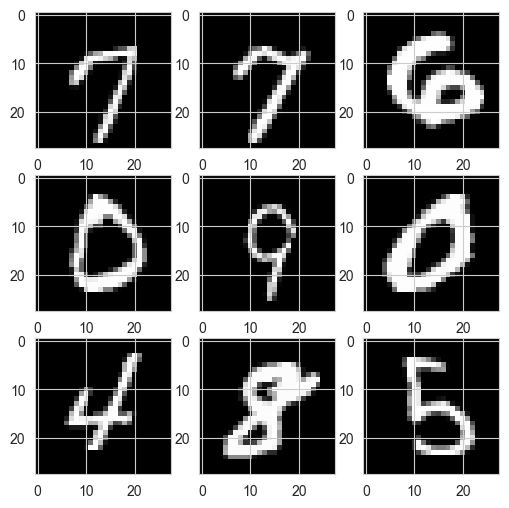

In [23]:
import matplotlib.pyplot as plt
import random

plt.figure(figsize=(6, 6))

random_idx = np.random.randint(0, len(train_images), size=9)

for i, idx in enumerate(random_idx) :

    img = train_images[idx]
    label = train_labels[idx]

    plt.subplot(3, 3, i+1)
    plt.imshow(img, cmap='gray')
    # plt.title(train_labels[idx])

plt.show()

In [24]:
from tensorflow.keras.utils import to_categorical

train_images = tf.cast(train_images, tf.float32) / 255.0
test_images = tf.cast(test_images, tf.float32) / 255.0

train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)

In [25]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten, Conv2D, MaxPooling2D

model = Sequential()
model.add(Input(shape=(28, 28, 1)))
model.add(Flatten(input_shape=[28, 28, 1]))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(10, activation='softmax'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 784)               0         
                                                                 
 dense_4 (Dense)             (None, 128)               100480    
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                                 
 dense_5 (Dense)             (None, 64)                8256      
                                                                 
 dropout_4 (Dropout)         (None, 64)                0         
                                                                 
 dense_6 (Dense)             (None, 32)                2080      
                                                                 
 dropout_5 (Dropout)         (None, 32)               

In [26]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard, ReduceLROnPlateau

checkpoint = ModelCheckpoint("model.h5", monitor="val_loss", mode="min", save_best_only=True, verbose=1)
earlystopping = EarlyStopping(monitor="val_loss", patience=5, verbose=1, mode='min')
tensorboard = TensorBoard(log_dir='./logs', histogram_freq=1, embeddings_freq=1, write_graph=True, write_images=True)
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=3, verbose=1, min_lr=0.00001)

In [27]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
history = model.fit(train_images, train_labels, epochs=30, batch_size=32, validation_split=0.2, callbacks=[checkpoint, earlystopping, tensorboard, reduce_lr])

Epoch 1/30
1491/1500 [============================>.] - ETA: 0s - loss: 0.4583 - acc: 0.8624
Epoch 1: val_loss improved from inf to 0.17363, saving model to model.h5
1500/1500 [==============================] - 3s 2ms/step - loss: 0.4571 - acc: 0.8629 - val_loss: 0.1736 - val_acc: 0.9508 - lr: 0.0010
Epoch 2/30
  36/1500 [..............................] - ETA: 2s - loss: 0.2118 - acc: 0.9366

c:\Users\euiso\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1486/1500 [============================>.] - ETA: 0s - loss: 0.2147 - acc: 0.9385
Epoch 2: val_loss improved from 0.17363 to 0.13036, saving model to model.h5
1500/1500 [==============================] - 3s 2ms/step - loss: 0.2154 - acc: 0.9385 - val_loss: 0.1304 - val_acc: 0.9627 - lr: 0.0010
Epoch 3/30
1467/1500 [============================>.] - ETA: 0s - loss: 0.1664 - acc: 0.9533
Epoch 3: val_loss improved from 0.13036 to 0.11783, saving model to model.h5
1500/1500 [==============================] - 3s 2ms/step - loss: 0.1671 - acc: 0.9531 - val_loss: 0.1178 - val_acc: 0.9666 - lr: 0.0010
Epoch 4/30
1469/1500 [============================>.] - ETA: 0s - loss: 0.1409 - acc: 0.9609
Epoch 4: val_loss improved from 0.11783 to 0.10733, saving model to model.h5
1500/1500 [==============================] - 3s 2ms/step - loss: 0.1407 - acc: 0.9610 - val_loss: 0.1073 - val_acc: 0.9703 - lr: 0.0010
Epoch 5/30
1473/1500 [============================>.] - ETA: 0s - loss: 0.1232 - acc: 0.9648


In [28]:
model.evaluate(test_images, test_labels, verbose=2)

313/313 - 0s - loss: 0.0846 - acc: 0.9811 - 319ms/epoch - 1ms/step


[0.08462392538785934, 0.9811000227928162]

In [29]:
pred_ys = model.predict(test_images)
print(pred_ys[0])
print(np.argmax(pred_ys[0]))

313/313 [==============================] - 0s 723us/step
[1.0000000e+00 1.2681488e-19 7.1084333e-13 1.0097287e-15 1.5902388e-19
 7.6103349e-14 1.3892971e-12 6.8672162e-13 7.0969814e-18 2.0696022e-14]
0


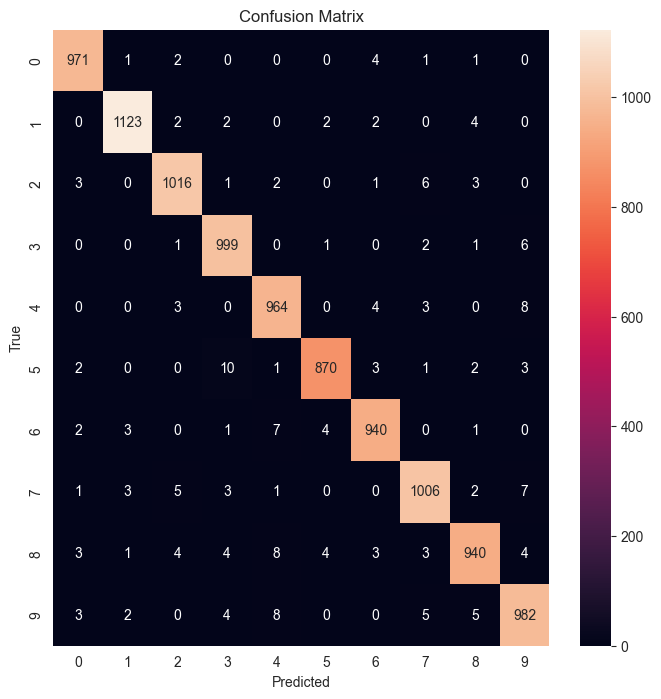

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

plt.figure(figsize=(8,8))

sns.set_style("whitegrid")
cm = confusion_matrix(np.argmax(test_labels, axis = -1), np.argmax(pred_ys, axis= -1))
sns.heatmap(cm, annot=True, fmt="d")
plt.ylabel('True')
plt.xlabel("Predicted")
plt.title("Confusion Matrix")

plt.show()